## Source

### http://csbdeep.bioimagecomputing.com/examples/denoising2D_probabilistic/

In [38]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import skimage
from skimage import external
from skimage.external import tifffile
from skimage import data, img_as_float
from skimage import exposure
from skimage.transform import rescale, resize, downscale_local_mean

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

In [4]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict

In [5]:
def train_test_val(folder_path, channels = 1, train_pp = .6, test_pp = .2, val_pp = .2, set_seed = 1):
    #check to make sure percentages equal 1
    if train_pp+test_pp+val_pp != 1:
        raise Exception("train, test, val percentages must equal 1")
    
    #check to make sure channels in 1-5
    for c in list((channels,6)):
        if c not in list(range(1,7)):
            raise Exception("channels can only be in range 1-5")
    
    #Find file paths
    for root, dirs, files in os.walk(folder_path):
        root_path = root
        root_dir = dirs
        root_files = files
    
    #split each file to find relevant numbers
    sample_zplanes_folder = []
    for file in root_files:
        s,c,z = file.split('_')
        s_n = s.strip('sample')
        c_n = c.strip('channel')
        z_n = z.strip('z').split('.')[0]
        #create new entries where first part of key is sample #
        #second part of key is zplane #
        entry = list([str(s_n)+str('_')+str(z_n), file])
        sample_zplanes_folder.append(entry)
    
    #create dictionary with new keys for sample # and zplane #
    d = defaultdict(list)
    for key, entry in sample_zplanes_folder:
        d[key].append(entry)
    
    #full dictionary of files with corresponding sample/zplane #
    samples = d
    #just sample/zplane keys used to split data
    samples_list = list(samples.keys())


    #set number entries base on pp's for train, test, val
    train_p, test_p, val_p = round((len(samples_list))*train_pp), \
                             round((len(samples_list))*test_pp), \
                             round((len(samples_list))*val_pp)

    #set train seed
    np.random.seed(set_seed)
    #select training set
    train = list(np.random.choice(samples_list, size=train_p, replace=False))
    #remove training set from original list
    samples_list = list(set(samples_list) - set(train))

    #set test seed
    np.random.seed(set_seed)
    #select training set
    test = list(np.random.choice(samples_list, size=test_p, replace=False))
    #remove training set from original list
    val = list(set(samples_list) - set(test))
    
    #set channel list
    channel_set = list((channels,6))
    
    #training data
    train_paths = []
    for t in train:
        entry = samples[t]
        train_paths.append(entry)

    train_final = []
    for file in train_paths:
        temp = []
        for channel_file in file:
            s,c,z = channel_file.split('_')
            c_n = c.strip('channel')
            for c in channel_set:
                if c_n == str(c):
                    temp.append(str(root_path)+str(channel_file))
        train_final.append(sorted(temp))  

    #test data
    test_paths = []
    for t in test:
        entry = samples[t]
        test_paths.append(entry)

    test_final = []
    for file in test_paths:
        temp = []
        for channel_file in file:
            s,c,z = channel_file.split('_')
            c_n = c.strip('channel')
            for c in channel_set:
                if c_n == str(c):
                    temp.append(str(root_path)+str(channel_file))
        test_final.append(sorted(temp)) 

    #validation data 
    val_paths = []
    for t in val:
        entry = samples[t]
        val_paths.append(entry)

    val_final = []
    for file in val_paths:
        temp = []
        for channel_file in file:
            s,c,z = channel_file.split('_')
            c_n = c.strip('channel')
            for c in channel_set:
                if c_n == str(c):
                    temp.append(str(root_path)+str(channel_file))
        val_final.append(sorted(temp))
    
    return(train_final, test_final, val_final)

In [6]:
folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/'

In [7]:

train, test, val = train_test_val(folder_path, \
                                  channels = 1, \
                                  train_pp = .6, \
                                  test_pp = .2, \
                                  val_pp = .2, \
                                  set_seed = 1)

In [8]:
train

[['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample31_channel1_z3.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample31_channel6_z3.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample111_channel1_z2.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample111_channel6_z2.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample2_channel1_z7.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample2_channel6_z7.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample97_channel1_z75.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample97_channel6_z75.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample119_channel1_z10.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample119_channel6_z10.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample116_channel1_z30.tif',
  '/gpfs/data/lionn

In [16]:
#read in X train
X = []
for i in range(0,len(train)):
    entry = skimage.external.tifffile.imread(train[i][0])
    X.append(entry)
    
X = np.array(X)

In [17]:
#read in X val
X_val = []
for i in range(0,len(val)):
    entry = skimage.external.tifffile.imread(val[i][0])
    X_val.append(entry)
    
X_val = np.array(X_val)

#read in X test
X_test = []
for i in range(0,len(test)):
    entry = skimage.external.tifffile.imread(test[i][0])
    X_test.append(entry)
    
X_test = np.array(X_test)


In [15]:
#read in Y train
Y = []
for i in range(0,len(train)):
    entry = skimage.external.tifffile.imread(train[i][1])
    Y.append(entry)
    
Y = np.array(Y)

In [18]:
#read in Y val
Y_val = []
for i in range(0,len(val)):
    entry = skimage.external.tifffile.imread(val[i][0])
    Y_val.append(entry)
    
Y_val = np.array(Y_val)

#read in Y test
Y_test = []
for i in range(0,len(test)):
    entry = skimage.external.tifffile.imread(test[i][0])
    Y_test.append(entry)
    
Y_test = np.array(Y_test)

In [32]:
#find new exposure scale

#create joint stack
ALL_IMGS = np.vstack((X,X_val,X_test,Y,Y_val,Y_test))

#find minimum intensity
for i in range(0,len(ALL_IMGS)):
    if i == 0:
        stack_min = ALL_IMGS[i].min()
        
    else:
        if ALL_IMGS[i].min() < stack_min:
            stack_min = ALL_IMGS[i].min()
        else: 
            stack_min = stack_min

#find maximum instensity
for i in range(0,len(ALL_IMGS)):
    if i == 0:
        stack_max = ALL_IMGS[i].max()
        
    else:
        if ALL_IMGS[i].max() > stack_max:
            stack_max = ALL_IMGS[i].max()
        else: 
            stack_max = stack_max

In [58]:
#rescale exposure intensity for all images 
#resize images --> 512 to 128 

#X train
X_TRAIN = []
for i in range(0,len(X)):
    image = exposure.rescale_intensity(X[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    X_TRAIN.append(image)
X_TRAIN = np.array(X_TRAIN)
    
#X val
X_VAL = []
for i in range(0,len(X_val)):
    image = exposure.rescale_intensity(X_val[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    X_VAL.append(image)
X_VAL = np.array(X_VAL)

#X test
X_TEST = []
for i in range(0,len(X_test)):
    image = exposure.rescale_intensity(X_test[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    X_TEST.append(image)
X_TEST = np.array(X_TEST)

#Y train
Y_TRAIN = []
for i in range(0,len(Y)):
    image = exposure.rescale_intensity(Y[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    Y_TRAIN.append(image)
Y_TRAIN = np.array(Y_TRAIN)
    
#Y val
Y_VAL = []
for i in range(0,len(Y_val)):
    image = exposure.rescale_intensity(Y_val[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    Y_VAL.append(image)
Y_VAL = np.array(Y_VAL)

#Y test
Y_TEST = []
for i in range(0,len(Y_test)):
    image = exposure.rescale_intensity(Y_test[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    Y_TEST.append(image)
Y_TEST = np.array(Y_TEST)

In [43]:
print(X_TRAIN.shape)
print(X_VAL.shape)
print(X_TEST.shape)
print(Y_TRAIN.shape)
print(Y_VAL.shape)
print(Y_TEST.shape)

(3886, 128, 128)
(1295, 128, 128)
(1295, 128, 128)
(3886, 128, 128)
(1295, 128, 128)
(1295, 128, 128)


In [68]:
#reshape X and Y --> (3886, 512, 512) to (3886, 512, 512, 1)

X_TRAIN = X_TRAIN.reshape(3886, 128, 128,1)
X_VAL = X_VAL.reshape(1295, 128, 128,1)
X_TEST = X_TEST.reshape(1295, 128, 128,1)
Y_TRAIN = Y_TRAIN.reshape(3886, 128, 128,1)
Y_VAL = Y_VAL.reshape(1295, 128, 128,1)
Y_TEST = Y_TEST.reshape(1295, 128, 128,1)



In [60]:
#original set (not rescaled, not resized)

#reshape X and Y --> (3886, 512, 512) to (3886, 512, 512, 1)

X = X.reshape(3886, 512, 512,1)
X_val = X_val.reshape(1295, 512, 512,1)
X_test = X_test.reshape(1295, 512, 512,1)
Y = Y.reshape(3886, 512, 512,1)
Y_val = Y_val.reshape(1295, 512, 512,1)
Y_test = Y_test.reshape(1295, 512, 512,1)

In [69]:
#Image Axes
#X: columns, Y: rows, Z: planes, C: channels, T: frames/time, (S: samples/images)
axes = 'SYXC'

c = axes_dict(axes)['C']
n_channel_in,n_channel_out = X_TRAIN.shape[c], Y_TRAIN.shape[c]


In [70]:
#set config file
config = Config(axes, n_channel_in, n_channel_out, probabilistic=True, train_steps_per_epoch=30)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=True, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='laplace', train_reduce_lr={'factor': 0.5, 'patience': 10}, train_steps_per_epoch=30, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': True,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'laplace',
 'train_epochs': 100,
 'train_steps_per_epoch': 30,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10}}

In [71]:
#create model
hn_model = CARE(config, 'hn_model', basedir='models')

In [72]:
#history
hn_history = hn_model.train(X_TRAIN,Y_TRAIN, validation_data=(X_VAL,Y_VAL))

Epoch 1/100
30/30 [==============================] - 3s 92ms/step - loss: 0.1071 - mse: 0.0047 - mae: 0.0567 - val_loss: 0.0028 - val_mse: 0.0105 - val_mae: 0.0990
Epoch 2/100
30/30 [==============================] - 2s 56ms/step - loss: -1.0416 - mse: 0.0026 - mae: 0.0407 - val_loss: -1.2561 - val_mse: 0.0021 - val_mae: 0.0442
Epoch 3/100
30/30 [==============================] - 2s 56ms/step - loss: -1.0985 - mse: 0.0021 - mae: 0.0365 - val_loss: -0.9648 - val_mse: 0.0029 - val_mae: 0.0517
Epoch 4/100
30/30 [==============================] - 2s 56ms/step - loss: -1.1806 - mse: 0.0024 - mae: 0.0365 - val_loss: -0.4682 - val_mse: 1.6748e-04 - val_mae: 0.0125
Epoch 5/100
30/30 [==============================] - 2s 56ms/step - loss: -1.2507 - mse: 0.0018 - mae: 0.0312 - val_loss: -1.5732 - val_mse: 8.2766e-04 - val_mae: 0.0280
Epoch 6/100
30/30 [==============================] - 2s 55ms/step - loss: -0.8803 - mse: 0.0018 - mae: 0.0331 - val_loss: -0.3428 - val_mse: 0.0031 - val_mae: 0.055

30/30 [==============================] - 2s 56ms/step - loss: -3.6343 - mse: 6.6979e-05 - mae: 0.0055 - val_loss: 1.1180 - val_mse: 0.0024 - val_mae: 0.0382
Epoch 49/100
30/30 [==============================] - 2s 56ms/step - loss: -3.7642 - mse: 6.2692e-05 - mae: 0.0050 - val_loss: 1.8218 - val_mse: 0.0024 - val_mae: 0.0374
Epoch 50/100
30/30 [==============================] - 2s 56ms/step - loss: -3.7099 - mse: 6.8123e-05 - mae: 0.0053 - val_loss: 2.5802 - val_mse: 0.0026 - val_mae: 0.0404

Epoch 00050: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 51/100
30/30 [==============================] - 2s 56ms/step - loss: -3.7939 - mse: 6.2960e-05 - mae: 0.0050 - val_loss: 3.2217 - val_mse: 0.0027 - val_mae: 0.0414
Epoch 52/100
30/30 [==============================] - 2s 56ms/step - loss: -3.8129 - mse: 5.9512e-05 - mae: 0.0049 - val_loss: 2.6935 - val_mse: 0.0026 - val_mae: 0.0397
Epoch 53/100
30/30 [==============================] - 2s 56ms/step - loss: -3.8027

Epoch 94/100
30/30 [==============================] - 2s 56ms/step - loss: -3.9436 - mse: 5.5153e-05 - mae: 0.0045 - val_loss: 3.6418 - val_mse: 0.0026 - val_mae: 0.0401
Epoch 95/100
30/30 [==============================] - 2s 56ms/step - loss: -3.9084 - mse: 5.7542e-05 - mae: 0.0047 - val_loss: 3.5805 - val_mse: 0.0026 - val_mae: 0.0400
Epoch 96/100
30/30 [==============================] - 2s 56ms/step - loss: -3.9539 - mse: 5.3171e-05 - mae: 0.0045 - val_loss: 3.5666 - val_mse: 0.0026 - val_mae: 0.0399
Epoch 97/100
30/30 [==============================] - 2s 56ms/step - loss: -3.9348 - mse: 5.3688e-05 - mae: 0.0045 - val_loss: 3.6214 - val_mse: 0.0026 - val_mae: 0.0399
Epoch 98/100
30/30 [==============================] - 2s 56ms/step - loss: -3.8702 - mse: 6.1029e-05 - mae: 0.0048 - val_loss: 3.5438 - val_mse: 0.0026 - val_mae: 0.0399
Epoch 99/100
30/30 [==============================] - 2s 56ms/step - loss: -3.9487 - mse: 5.3935e-05 - mae: 0.0045 - val_loss: 3.6217 - val_mse: 0.002

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


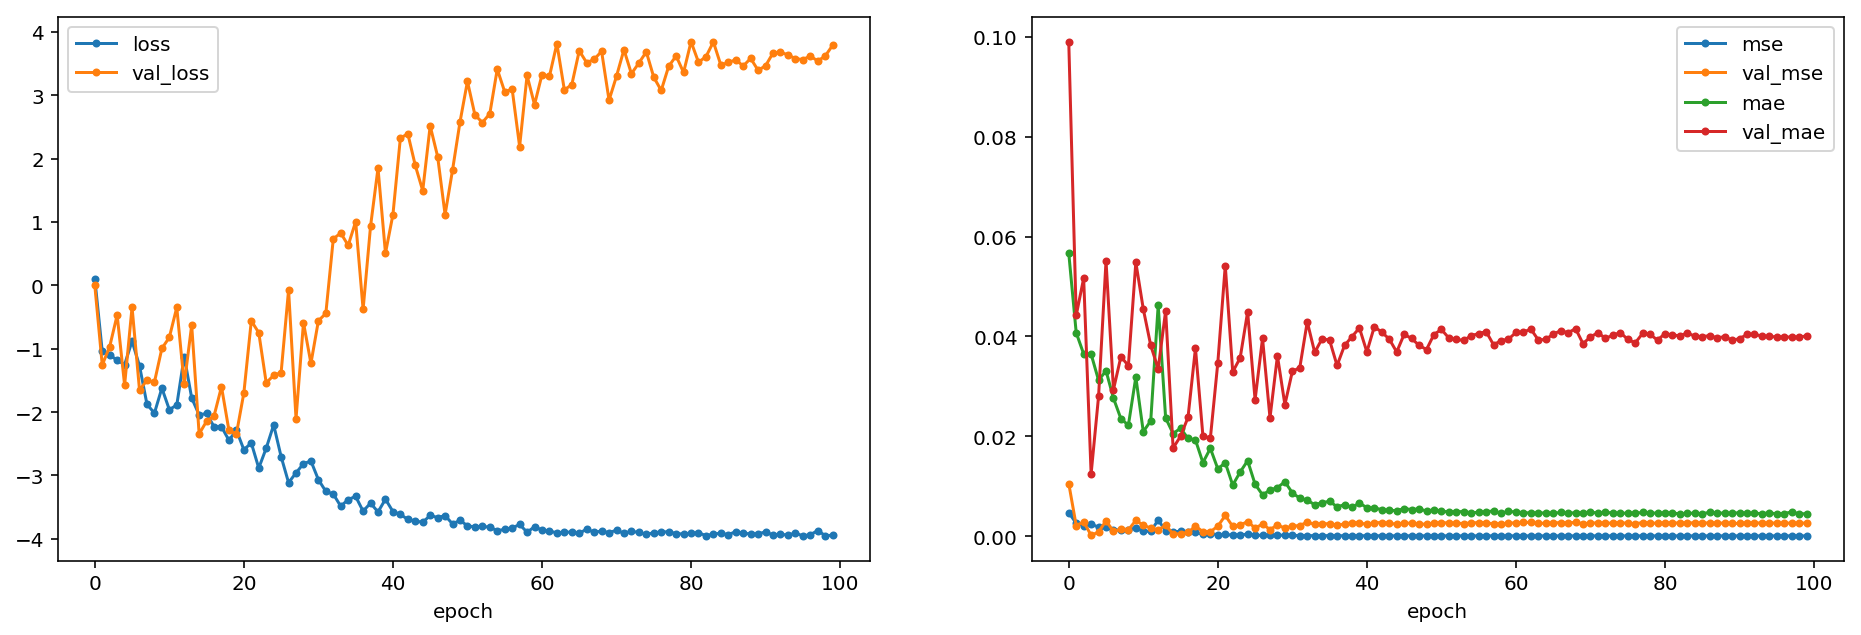

In [77]:
print(sorted(list(hn_history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(hn_history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

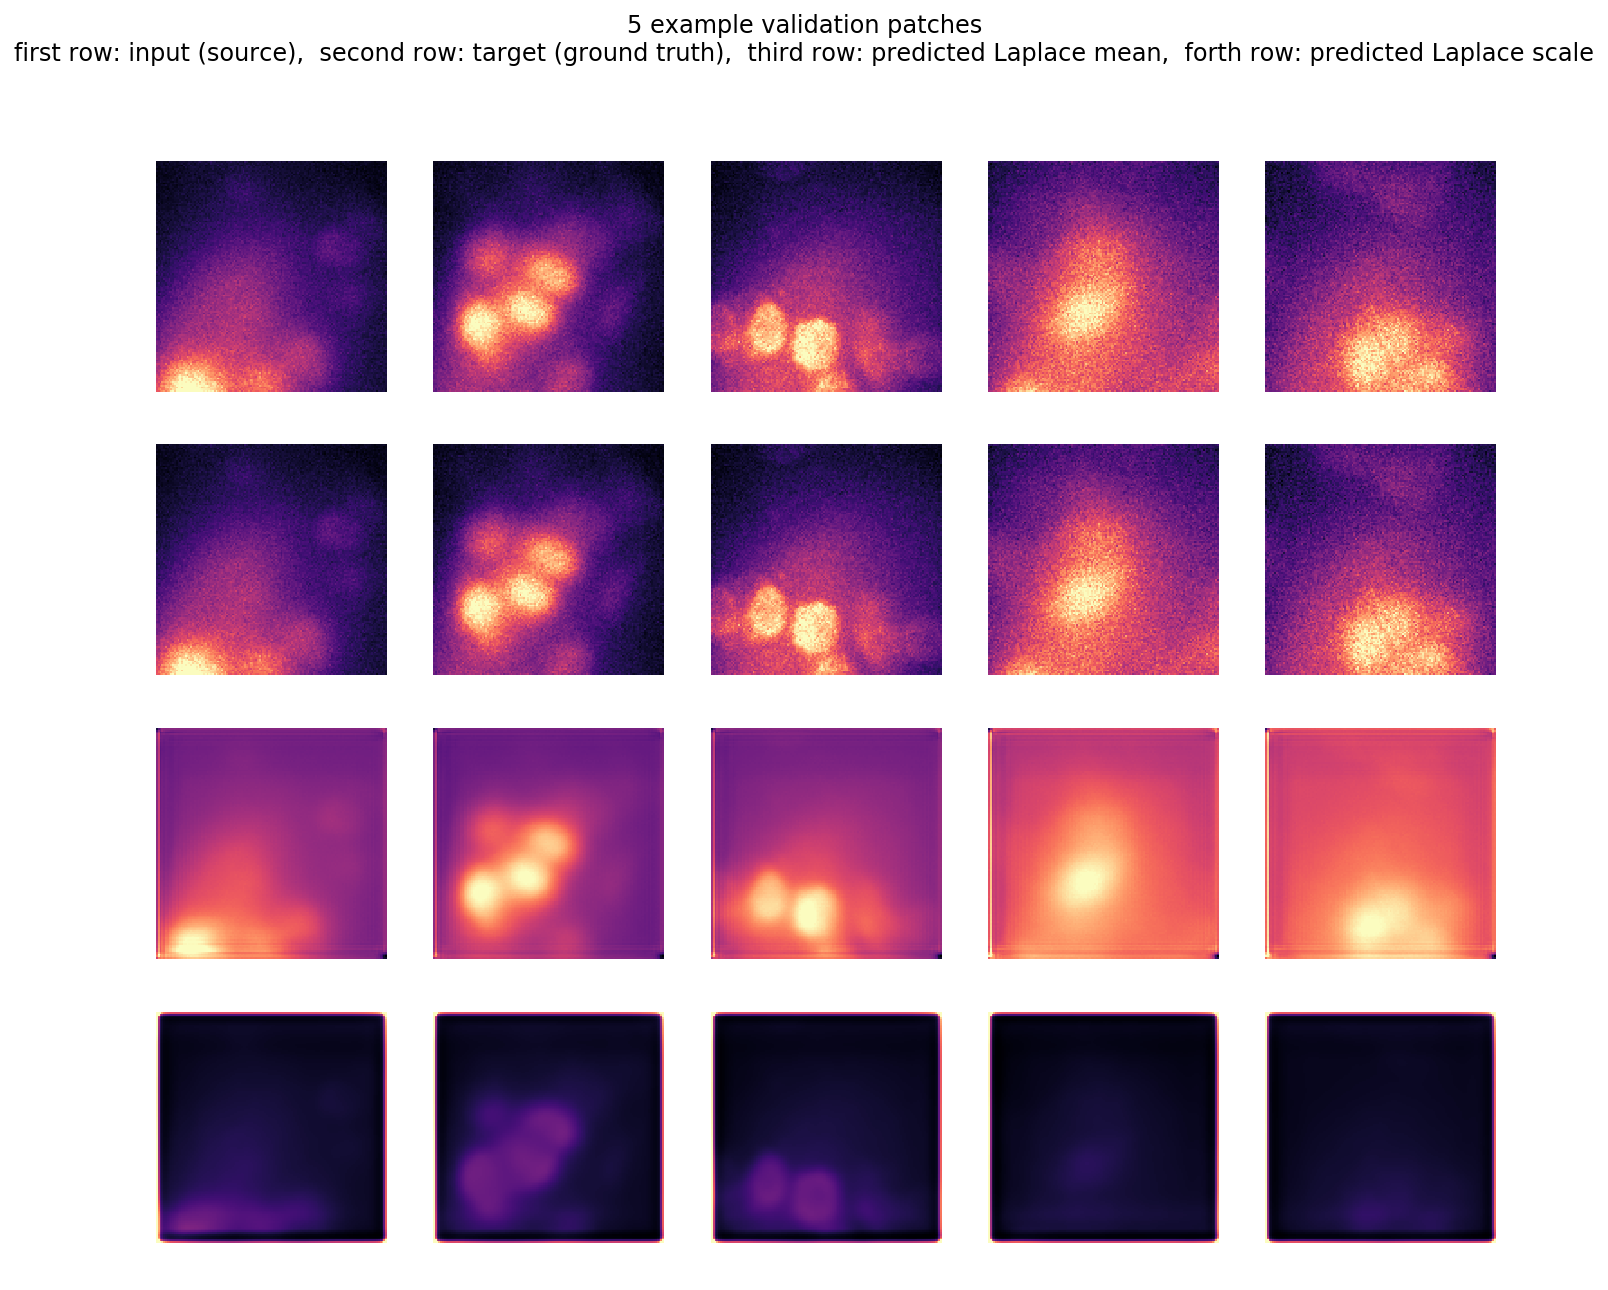

In [78]:
plt.figure(figsize=(12,10))
_P = hn_model.keras_model.predict(X_VAL[:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_VAL[:5],Y_VAL[:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

In [61]:
#ORIGINAL UNCHANGED DATA

#Image Axes
#X: columns, Y: rows, Z: planes, C: channels, T: frames/time, (S: samples/images)
axes = 'SYXC'

c = axes_dict(axes)['C']
O_n_channel_in,O_n_channel_out = X.shape[c], Y.shape[c]


In [62]:
#ORIGINAL UNCHANGED DATA
#set config file
O_config = Config(axes, O_n_channel_in, O_n_channel_out, probabilistic=True, train_steps_per_epoch=30)
print(O_config)
vars(O_config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=True, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='laplace', train_reduce_lr={'factor': 0.5, 'patience': 10}, train_steps_per_epoch=30, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': True,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'laplace',
 'train_epochs': 100,
 'train_steps_per_epoch': 30,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10}}

In [79]:
#ORIGINAL UNCHANGED DATA
#create model
O_model = CARE(O_config, 'O_my_model', basedir='models')

In [80]:
#ORIGINAL UNCHANGED DATA
#history
O_history = O_model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
30/30 [==============================] - 33s 1s/step - loss: 195.7575 - mse: 4999584.0479 - mae: 1589.0095 - val_loss: 9.7645 - val_mse: 4545569.8618 - val_mae: 1985.6922
Epoch 2/100
30/30 [==============================] - 25s 844ms/step - loss: 8.7174 - mse: 2151845.7479 - mae: 928.2454 - val_loss: 9.4157 - val_mse: 3245100.0946 - val_mae: 1678.9965
Epoch 3/100
30/30 [==============================] - 25s 846ms/step - loss: 8.0778 - mse: 1139296.6437 - mae: 674.9612 - val_loss: 9.8526 - val_mse: 3483974.7129 - val_mae: 1738.9535
Epoch 4/100
30/30 [==============================] - 25s 845ms/step - loss: 8.0322 - mse: 1151757.2354 - mae: 660.9971 - val_loss: 9.7999 - val_mse: 3562610.5085 - val_mae: 1752.2566
Epoch 5/100
30/30 [==============================] - 30s 991ms/step - loss: 8.0231 - mse: 1157714.5686 - mae: 660.9750 - val_loss: 9.7568 - val_mse: 3317818.6936 - val_mae: 1684.3789
Epoch 6/100
30/30 [==============================] - 25s 846ms/step - loss: 7.9983 - 

30/30 [==============================] - 25s 848ms/step - loss: 7.4507 - mse: 291490.3594 - mae: 360.8871 - val_loss: 11.2376 - val_mse: 5934047.9212 - val_mae: 1905.9261
Epoch 45/100
30/30 [==============================] - 25s 849ms/step - loss: 7.4590 - mse: 301334.0047 - mae: 365.3437 - val_loss: 11.1263 - val_mse: 5767038.3764 - val_mae: 1863.1576
Epoch 46/100
30/30 [==============================] - 25s 848ms/step - loss: 7.4434 - mse: 284964.2104 - mae: 357.2449 - val_loss: 11.1823 - val_mse: 5777374.9857 - val_mae: 1866.0044
Epoch 47/100
30/30 [==============================] - 25s 849ms/step - loss: 7.4519 - mse: 287799.4422 - mae: 360.8778 - val_loss: 11.0478 - val_mse: 5276625.5618 - val_mae: 1779.8155

Epoch 00047: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 48/100
30/30 [==============================] - 25s 849ms/step - loss: 7.4374 - mse: 285519.5745 - mae: 356.5638 - val_loss: 11.2064 - val_mse: 5759853.2452 - val_mae: 1879.5862
Epoch 49/100

Epoch 87/100
30/30 [==============================] - 25s 849ms/step - loss: 7.4125 - mse: 276219.9922 - mae: 350.2868 - val_loss: 11.3184 - val_mse: 5672917.0274 - val_mae: 1858.3090

Epoch 00087: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 88/100
30/30 [==============================] - 25s 849ms/step - loss: 7.4274 - mse: 296686.3236 - mae: 357.6726 - val_loss: 11.4164 - val_mse: 5961258.2834 - val_mae: 1920.2575
Epoch 89/100
30/30 [==============================] - 25s 850ms/step - loss: 7.4049 - mse: 276378.8557 - mae: 348.1320 - val_loss: 11.3826 - val_mse: 5870236.9363 - val_mae: 1899.7917
Epoch 90/100
30/30 [==============================] - 25s 848ms/step - loss: 7.4162 - mse: 274787.5547 - mae: 350.3255 - val_loss: 11.3282 - val_mse: 5685003.7012 - val_mae: 1862.3812
Epoch 91/100
30/30 [==============================] - 25s 850ms/step - loss: 7.4074 - mse: 274633.8406 - mae: 347.7364 - val_loss: 11.3564 - val_mse: 5812629.5313 - val_mae: 1884.3046


['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


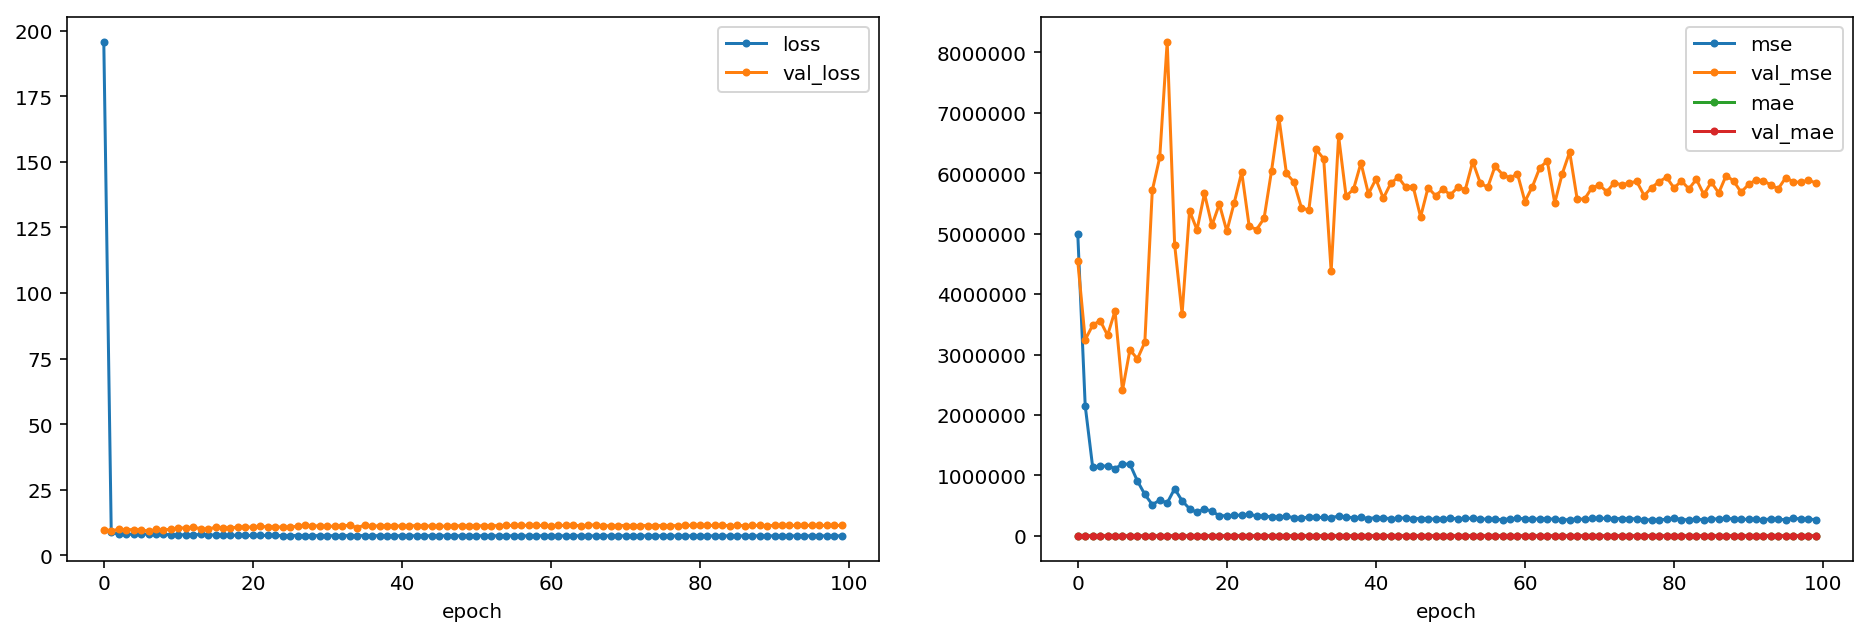

In [81]:
print(sorted(list(O_history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(O_history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

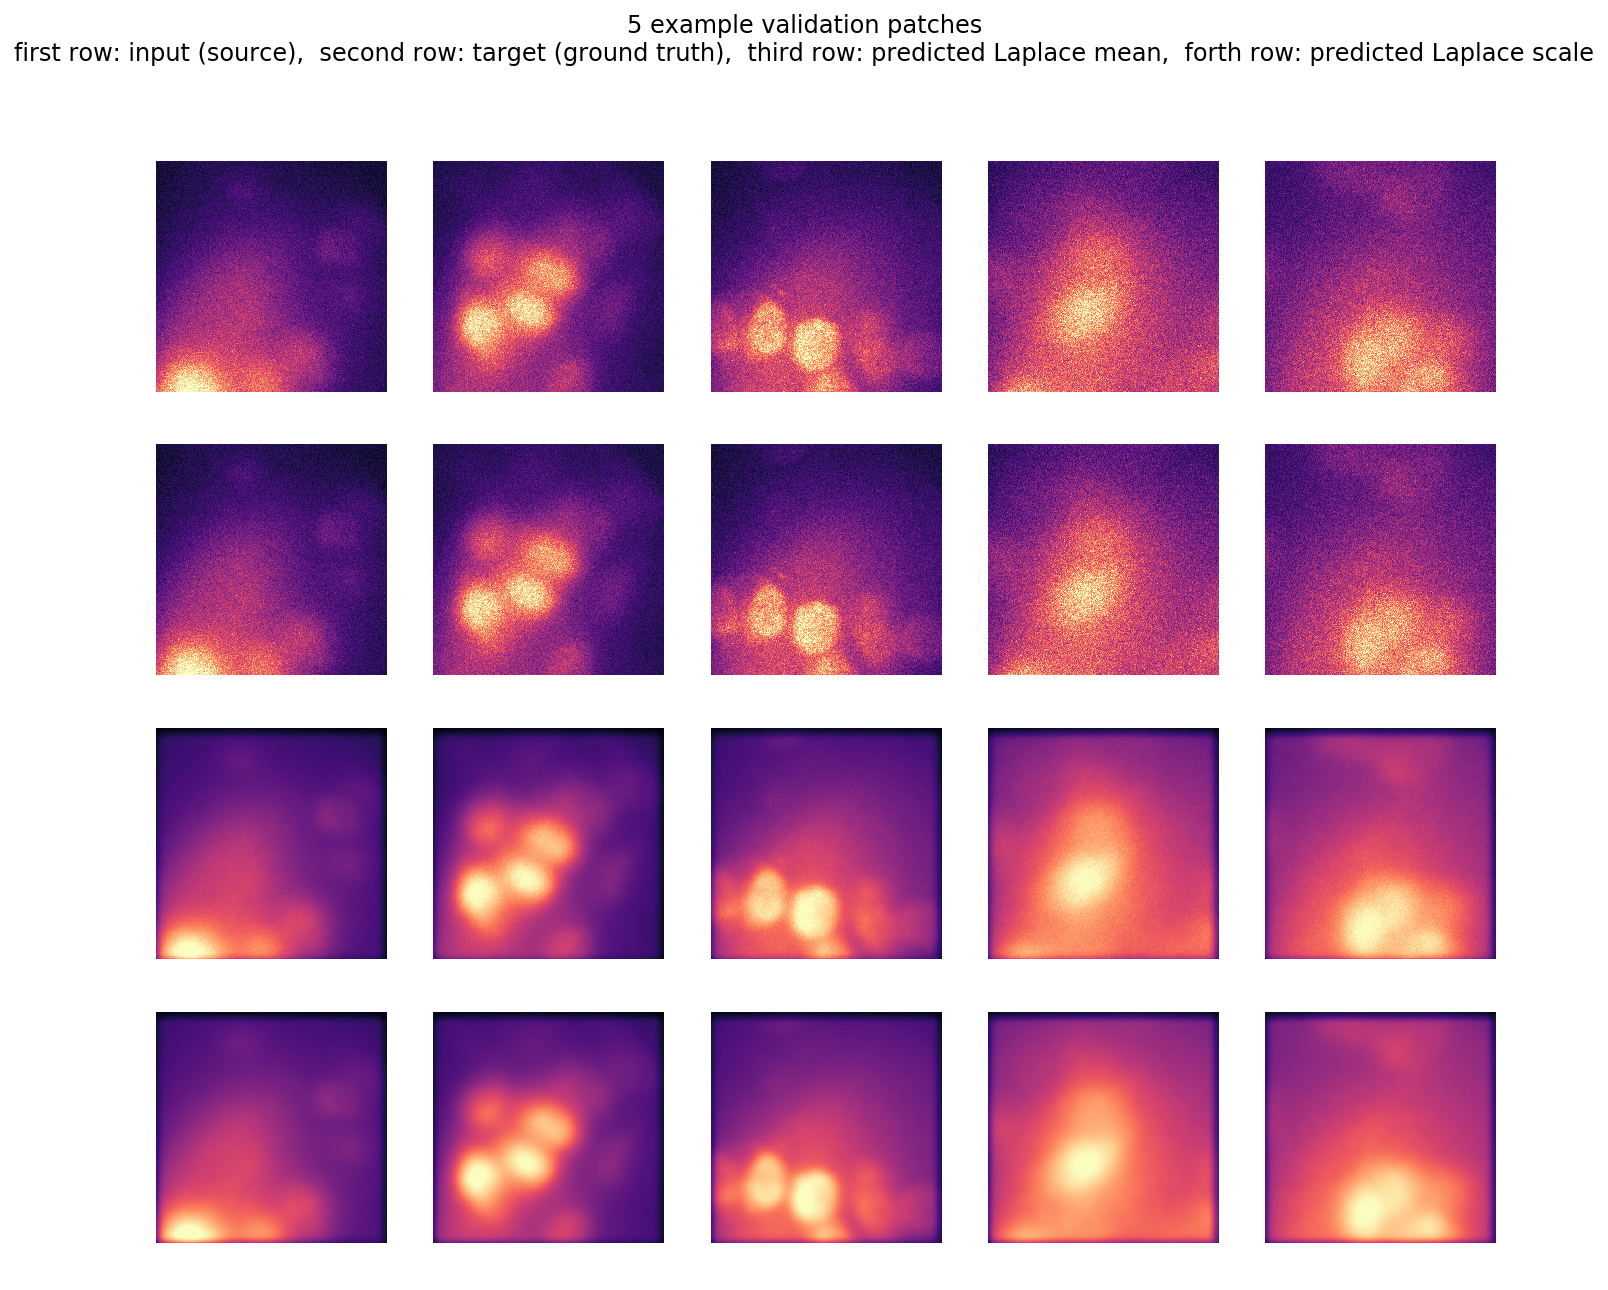

In [82]:
plt.figure(figsize=(12,10))
_P = O_model.keras_model.predict(X_val[:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_val[:5],Y_val[:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

## Predictions
